In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import torch as tc
genders = ['female', 'male']

In [2]:
their_semantics = [
    'Subject',
    'Measuring station',
    'repetition no.',
    'Bust girth',
    'Waist girth',
    'Hip girth',
    'Thigh girth R',
    'Upper arm girth R',
    'Neck girth',
    'Back neck point to waist',
    'Height (m)',
]
our_semantic = [
    'subject',
    'measures_station',
    'repetition',
    'bust_chest_girth', # 5.3.4
    'waist_girth', # 5.3.10
    'hip_girth', # 5.3.13
    'thigh_girth', # 5.3.20
    'upper_arm_girth', # 5.3.16
    'neck_girth', # 5.3.2
    'neck_waist',
    'stature', # 5.1.1
]

station_list = ["SS20", "Expert", "Our"]

measures = pd.read_pickle(f'data/ss20_cleaned_measures.zip')
measures = measures[their_semantics]
measures.columns = our_semantic
our_measures = pd.read_pickle("data/ss20_our_measures.zip")
measures = pd.concat([our_measures, measures]).drop(columns=["stature"])
measures = measures[measures['measures_station'].isin(["SS20", "Expert measurer 1", "our"])]
measures.replace("Expert measurer 1", "Expert", inplace=True)
measures.replace("our", "Our", inplace=True)
measures.reset_index(drop=True, inplace=True)

In [3]:
measures.to_csv("our_ss20.csv")

In [4]:
numeric = ['upper_arm_girth', 'neck_waist']
np.set_printoptions(suppress=True)
data = measures[:118][measures[:118]['repetition'] == 1][numeric].to_numpy() - measures[:118][measures[:118]['repetition'] == 2][numeric].to_numpy()
#data

In [5]:
measures.drop([98,99], inplace=True)

<AxesSubplot:xlabel='measure', ylabel='measure_value'>

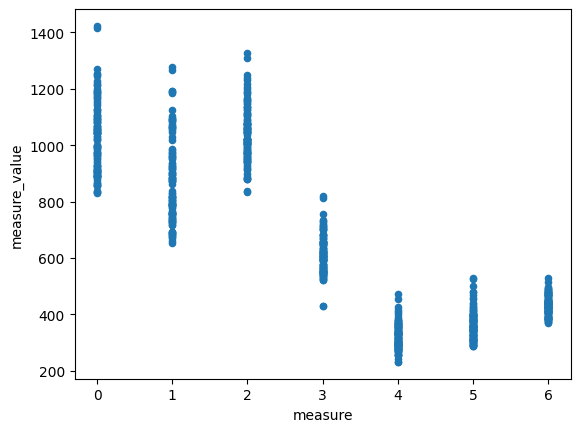

In [14]:
measures_semantic = ['bust_chest_girth', 'waist_girth', 'hip_girth', 'thigh_girth', 'upper_arm_girth', 'neck_girth', 'neck_waist', ]
a = measures[measures['measures_station']=="Our"][measures_semantic].reset_index(drop=True)
a = pd.melt(a)
a['variable'] = a.variable.factorize()[0]
a.plot(kind='scatter', x='variable', y='value', xlabel="measure", ylabel='measure value')

<AxesSubplot:xlabel='measure', ylabel='difference(mm)'>

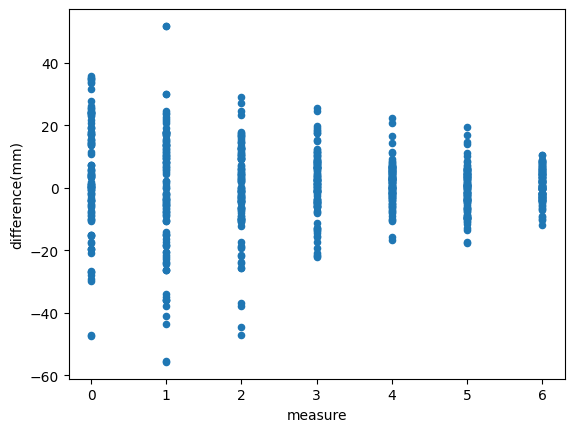

In [16]:
measures_semantic = ['bust_chest_girth', 'waist_girth', 'hip_girth', 'thigh_girth', 'upper_arm_girth', 'neck_girth', 'neck_waist', ]
a = measures[measures['measures_station']=="Our"][measures_semantic].reset_index(drop=True)
b = measures[measures['measures_station']=="SS20"][measures_semantic].reset_index(drop=True)
size = a.shape[1]

c =pd.melt((a-b)/10)
c['variable'] = c.variable.factorize()[0]
c.plot(kind='scatter', x='variable', y='value', xlabel="measure", ylabel='difference(mm)')

<AxesSubplot:xlabel='measure', ylabel='difference(mm)'>

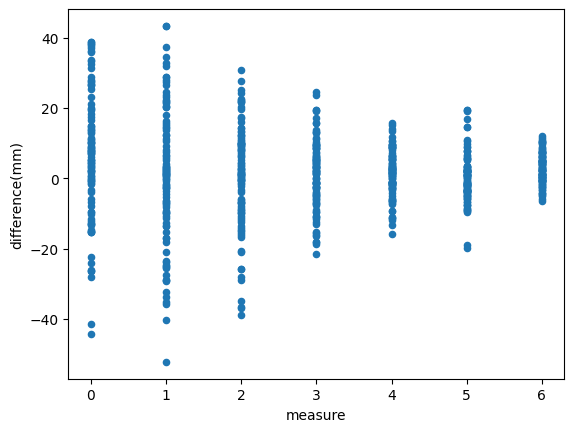

In [17]:
measures_semantic = ['bust_chest_girth', 'waist_girth', 'hip_girth', 'thigh_girth', 'upper_arm_girth', 'neck_girth', 'neck_waist', ]
a = measures[measures['measures_station']=="Our"][measures_semantic].reset_index(drop=True)
b = measures[measures['measures_station']=="Expert"][measures_semantic].reset_index(drop=True)
size = a.shape[1]

c =pd.melt((a-b)/10)
c['variable'] = c.variable.factorize()[0]
c.plot(kind='scatter', x='variable', y='value', xlabel="measure", ylabel='difference(mm)')

<AxesSubplot:xlabel='variable', ylabel='value'>

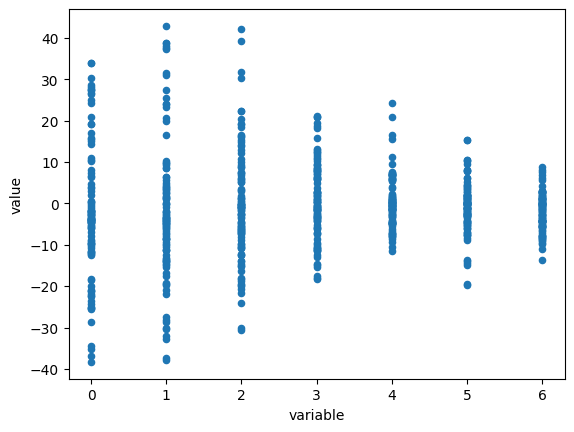

In [18]:
measures_semantic = ['bust_chest_girth', 'waist_girth', 'hip_girth', 'thigh_girth', 'upper_arm_girth', 'neck_girth', 'neck_waist', ]
a = measures[measures['measures_station']=="Expert"][measures_semantic].reset_index(drop=True)
b = measures[measures['measures_station']=="SS20"][measures_semantic].reset_index(drop=True)
size = a.shape[1]

c = pd.melt((a-b)/10)
c['variable'] = c.variable.factorize()[0]
c.plot(kind='scatter', x='variable', y='value')

# CALC ICC

In [6]:
def calc_icc(a):
    # ONE WAY ANOVA
    numsub, numrep, numel = a.shape[0], a.shape[1], a.size
    mean_between = a.mean(axis=1)
    mean_within  = a.mean(axis=0)
    ssw = ((a - mean_within)**2).sum()
    ssb = ((a.T - mean_between)**2).sum()
    msw = ssw/(numsub-1)
    msb = ssb/(numel-numsub)
    # ICC
    # icc = msw/(msw+msb)
    icc = (msw-msb) / ( msw + (numrep-1) * msb)
    return icc

In [7]:

all_measures = []
for station in station_list:
    measures_of_station = []
    for measure in our_semantic[3:-1]:
        a = measures[measures['measures_station'] == station][['subject', 'repetition', measure]]
        a = pd.pivot_table(a, index='subject', columns='repetition').to_numpy()
        icc = calc_icc(a)
        measures_of_station.append(icc)
    all_measures.append(measures_of_station)
our_icc = pd.DataFrame(all_measures, station_list, our_semantic[3:-1]).sort_index()

In [8]:
our_icc.index = ['Expert', 'Our', "SS20"]
our_icc

,bust_chest_girth,waist_girth,hip_girth,thigh_girth,upper_arm_girth,neck_girth,neck_waist
Expert,0.992813,0.983097,0.982067,0.975099,0.985897,0.980519,0.880718
Our,0.997479,0.996334,0.995272,0.992424,0.971522,0.991000,0.886424
SS20,0.997559,0.994638,0.993575,0.982322,0.990344,0.991896,0.966569


# CALC SEM

In [9]:
all_measures = []
for station in station_list:
    measures_of_station = []
    for measure in our_semantic[3:-1]:
        a = measures[measures['measures_station'] == station][['subject', 'repetition', measure]]
        b = pd.pivot_table(a, index='subject', columns='repetition').to_numpy()
        icc = calc_icc(b)
        sem = a[measure].std() * np.sqrt(1-icc)
        measures_of_station.append(sem)
    all_measures.append(measures_of_station)
our_sem = pd.DataFrame(all_measures, station_list, our_semantic[3:-1]).sort_index()

In [10]:
our_sem.index = ['Expert', "SS20", 'Our']
our_sem.T.round(4)

,Expert,SS20,Our
bust_chest_girth,10.8432,6.3283,6.7248
waist_girth,17.6614,8.9595,10.2937
hip_girth,14.9929,6.6426,7.9938
thigh_girth,11.2816,5.8041,9.0074
upper_arm_girth,5.1265,7.4835,4.5148
neck_girth,5.8890,4.8202,4.4899
neck_waist,10.2074,11.3672,7.4990


# CALC PSD

In [11]:
def calculate_psd(measure):
    data = measures
    f1 = data['repetition'] == 1
    f2 = data['repetition'] == 2
    data = data[ f1 | f2 ][['subject', 'measures_station', 'repetition', measure]]
    data = data.pivot_table(values=measure, index=['subject', 'repetition'], columns="measures_station")
    data = data.dropna()
    

    column_wise = []
    for column1 in data.columns:
        row_wise = []
        for column2 in data.columns:
            if column1 == column2:
                row_wise.append(np.nan)
            else:
                d1 = data[column1]
                d2 = data[column2]
                var = (d1-d2).var()
                sem1 = our_sem[measure].loc[column1]**2
                sem2 = our_sem[measure].loc[column2]**2
                value = np.sqrt(var + (sem1/2) + (sem2/2))
                row_wise.append(value)
        column_wise.append(row_wise)
    data = pd.DataFrame(column_wise, index=data.columns, columns=data.columns)
    data.index.name = None
    return data

In [12]:
neck_result = calculate_psd(measure='neck_girth')
MX = pd.Series({"SS20/Expert": neck_result.loc["SS20"]["Expert"]})
neck_result = neck_result.loc['Our'].drop('Our').append(MX)

In [13]:
bust_result = calculate_psd(measure='bust_chest_girth')
MX = pd.Series({"SS20/Expert": bust_result.loc["SS20"]["Expert"]})
bust_result = bust_result.loc['Our'].drop('Our').append(MX)

In [14]:
waist_result = calculate_psd(measure='waist_girth')
MX = pd.Series({"SS20/Expert": waist_result.loc["SS20"]["Expert"]})
waist_result = waist_result.loc['Our'].drop('Our').append(MX)

In [15]:
hip_result = calculate_psd(measure='hip_girth')
MX = pd.Series({"SS20/Expert": hip_result.loc["SS20"]["Expert"]})
hip_result = hip_result.loc['Our'].drop('Our').append(MX)

In [16]:
arm_result = calculate_psd(measure='upper_arm_girth')
MX = pd.Series({"SS20/Expert": arm_result.loc["SS20"]["Expert"]})
arm_result = arm_result.loc['Our'].drop('Our').append(MX)

In [17]:
thigh_result = calculate_psd(measure='thigh_girth')
MX = pd.Series({"SS20/Expert": thigh_result.loc["SS20"]["Expert"]})
thigh_result = thigh_result.loc['Our'].drop('Our').append(MX)

In [18]:
neck_waist_result = calculate_psd(measure='neck_waist')
MX = pd.Series({"SS20/Expert": neck_waist_result.loc["SS20"]["Expert"]})
neck_waist_result = neck_waist_result.loc['Our'].drop('Our').append(MX)

In [19]:
def calculate_mad():
    all_measures = []
    for station in station_list:
        measures_of_station = []
        a = measures[measures['measures_station'] == station]
        f1 = a['repetition'] == 1
        f2 = a['repetition'] == 2

        
        for measure in our_semantic[3:-1]:
            mean = np.nanmean(abs(a[f1][measure].to_numpy() - a[f2][measure].to_numpy()))
            measures_of_station.append(mean)

        all_measures.append(measures_of_station)
    return pd.DataFrame(all_measures, columns=our_semantic[3:-1], index=['Our','Expert','SS20']).T

In [20]:
calculate_mad()

,Our,Expert,SS20
bust_chest_girth,7.630763,10.181818,7.296091
waist_girth,7.901983,16.227273,9.793399
hip_girth,7.131373,13.500000,7.163131
thigh_girth,6.089542,12.590909,5.850343
upper_arm_girth,4.507424,5.000000,7.947104
neck_girth,4.574153,6.545455,5.226101
neck_waist,7.479008,11.636364,10.034299


In [21]:
styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "125%"),
                              ("color", 'black'),
                              ("font-weight", '700')])]

In [22]:
mad_table = calculate_mad().round(4)
mad_table = mad_table.style.set_caption("OUR vs SS20 MAD statistic result").set_table_styles(styles)
mad_table.format(precision=4)

,Our,Expert,SS20
bust_chest_girth,7.6308,10.1818,7.2961
waist_girth,7.9020,16.2273,9.7934
hip_girth,7.1314,13.5000,7.1631
thigh_girth,6.0895,12.5909,5.8503
upper_arm_girth,4.5074,5.0000,7.9471
neck_girth,4.5742,6.5455,5.2261
neck_waist,7.4790,11.6364,10.0343


In [23]:
sem_table = our_sem.T.round(4)
sem_table = sem_table.style.set_caption("OUR vs SS20 SEM statistic result").set_table_styles(styles)
sem_table.format(precision=4)

,Expert,SS20,Our
bust_chest_girth,10.8432,6.3283,6.7248
waist_girth,17.6614,8.9595,10.2937
hip_girth,14.9929,6.6426,7.9938
thigh_girth,11.2816,5.8041,9.0074
upper_arm_girth,5.1265,7.4835,4.5148
neck_girth,5.8890,4.8202,4.4899
neck_waist,10.2074,11.3672,7.4990


In [24]:
data_psd = pd.DataFrame(
    [neck_result, bust_result, waist_result, hip_result, arm_result,thigh_result, neck_waist_result],
    index=our_semantic[3:-1]).round(2)
data_psd.columns = ['Our vs Expert', "Our vs SS20", 'SS20 vs Expert']
data_psd.to_csv("output/our_psd.csv")
data_psd = data_psd.style.set_caption("OUR vs SS20 PSD statistic result").set_table_styles(styles)
data_psd.format(precision=2)

,Our vs Expert,Our vs SS20,SS20 vs Expert
bust_chest_girth,24.76,16.26,23.69
waist_girth,32.68,22.16,36.15
hip_girth,63.85,38.00,54.87
thigh_girth,34.23,24.56,32.05
upper_arm_girth,13.53,32.59,33.35
neck_girth,24.61,17.75,22.15
neck_waist,31.42,31.76,33.04
